In [1]:
%store -r sheyenne_grasslands_gdf caddo_grasslands_gdf data_dir

In [2]:
# Import necessary packages
import os
import pathlib
from glob import glob

import cartopy.crs as ccrs # CRSs
import pandas as pd # Aggregating and data manipulation
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
import xarray as xr

## Load in climate data

For each grassland: Download one climate variable from the MACAv2 THREDDS data server as raster data.

MACA v2 model: CanESM2
* Climate variable: precipitation
* Emissions scenarios being compared: rcp4.5 and rcp8.5
* Time period: 2076 - 2080
* Monthly predictions

In [3]:
# # Make MACA data directory
# maca_85_dir = os.path.join(data_dir, 'maca-85')
# os.makedirs(maca_85_dir, exist_ok=True)
# maca_85_dir

# maca_85_path = os.path.join(maca_85_dir, '.*nc')

# # Only download once
# if not os.path.exists(maca_85_path):
#     maca_85_ds = xr.open_dataset(maca_85_url)
#     maca_85_ds.to_netcdf(maca_85_path)

In [4]:
# Define function to convert longitude/latitude
def convert_longitude(longitude):
    """Convert longitude range from 0-360 t0 -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

maca_da_list = []
for site_name, site_gdf in {
    'Sheyenne Grasslands': sheyenne_grasslands_gdf,
    'Caddo Grasslands': caddo_grasslands_gdf}.items():
    for rcp_value in ['rcp85', 'rcp45']:
        # Define url
        maca_url = (
            'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
            '/MACAV2/CanESM2'
            '/macav2metdata_pr_CanESM2_r1i1p1'
            f'_{rcp_value}'
            '_2076_2080_CONUS'
            '_monthly.nc')

        # Squeeze Dataset
        maca_da = xr.open_dataset(maca_url).squeeze().precipitation

        # Define bounds
        bounds_maca = (site_gdf
                        .to_crs(maca_da.rio.crs)
                        .total_bounds)

        # Change maca_ds longitude values to match the grasslands gdfs
        maca_da = maca_da.assign_coords(
            lon=("lon", [convert_longitude(l) for l in maca_da.lon.values]))

        # Set spatial dimensions of maca_da
        maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

        # Crop maca_da
        maca_da = maca_da.rio.clip_box(*bounds_maca)
        maca_da_list.append(dict(
            site_name=site_name,
            rcp_value=rcp_value,
            da=maca_da))

maca_df = pd.DataFrame(maca_da_list)
maca_df

,site_name,rcp_value,da
0,Sheyenne Grasslands,rcp85,[[[<xarray.DataArray 'precipitation' ()> Size:...
1,Sheyenne Grasslands,rcp45,[[[<xarray.DataArray 'precipitation' ()> Size:...
2,Caddo Grasslands,rcp85,[[[<xarray.DataArray 'precipitation' ()> Size:...
3,Caddo Grasslands,rcp45,[[[<xarray.DataArray 'precipitation' ()> Size:...


In [35]:
sheyenne_85_da = maca_df.loc[0, 'da']
sheyenne_85_da

<xarray.DataArray 'precipitation' (time: 60, lat: 12, lon: 14)> Size: 40kB
[10080 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 96B 46.1 46.15 46.19 46.23 ... 46.48 46.52 46.56
  * time     (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:00:00
  * lon      (lon) float64 112B -97.48 -97.44 -97.4 ... -97.02 -96.98 -96.94
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<function matplotlib.pyplot.show(close=None, block=None)>

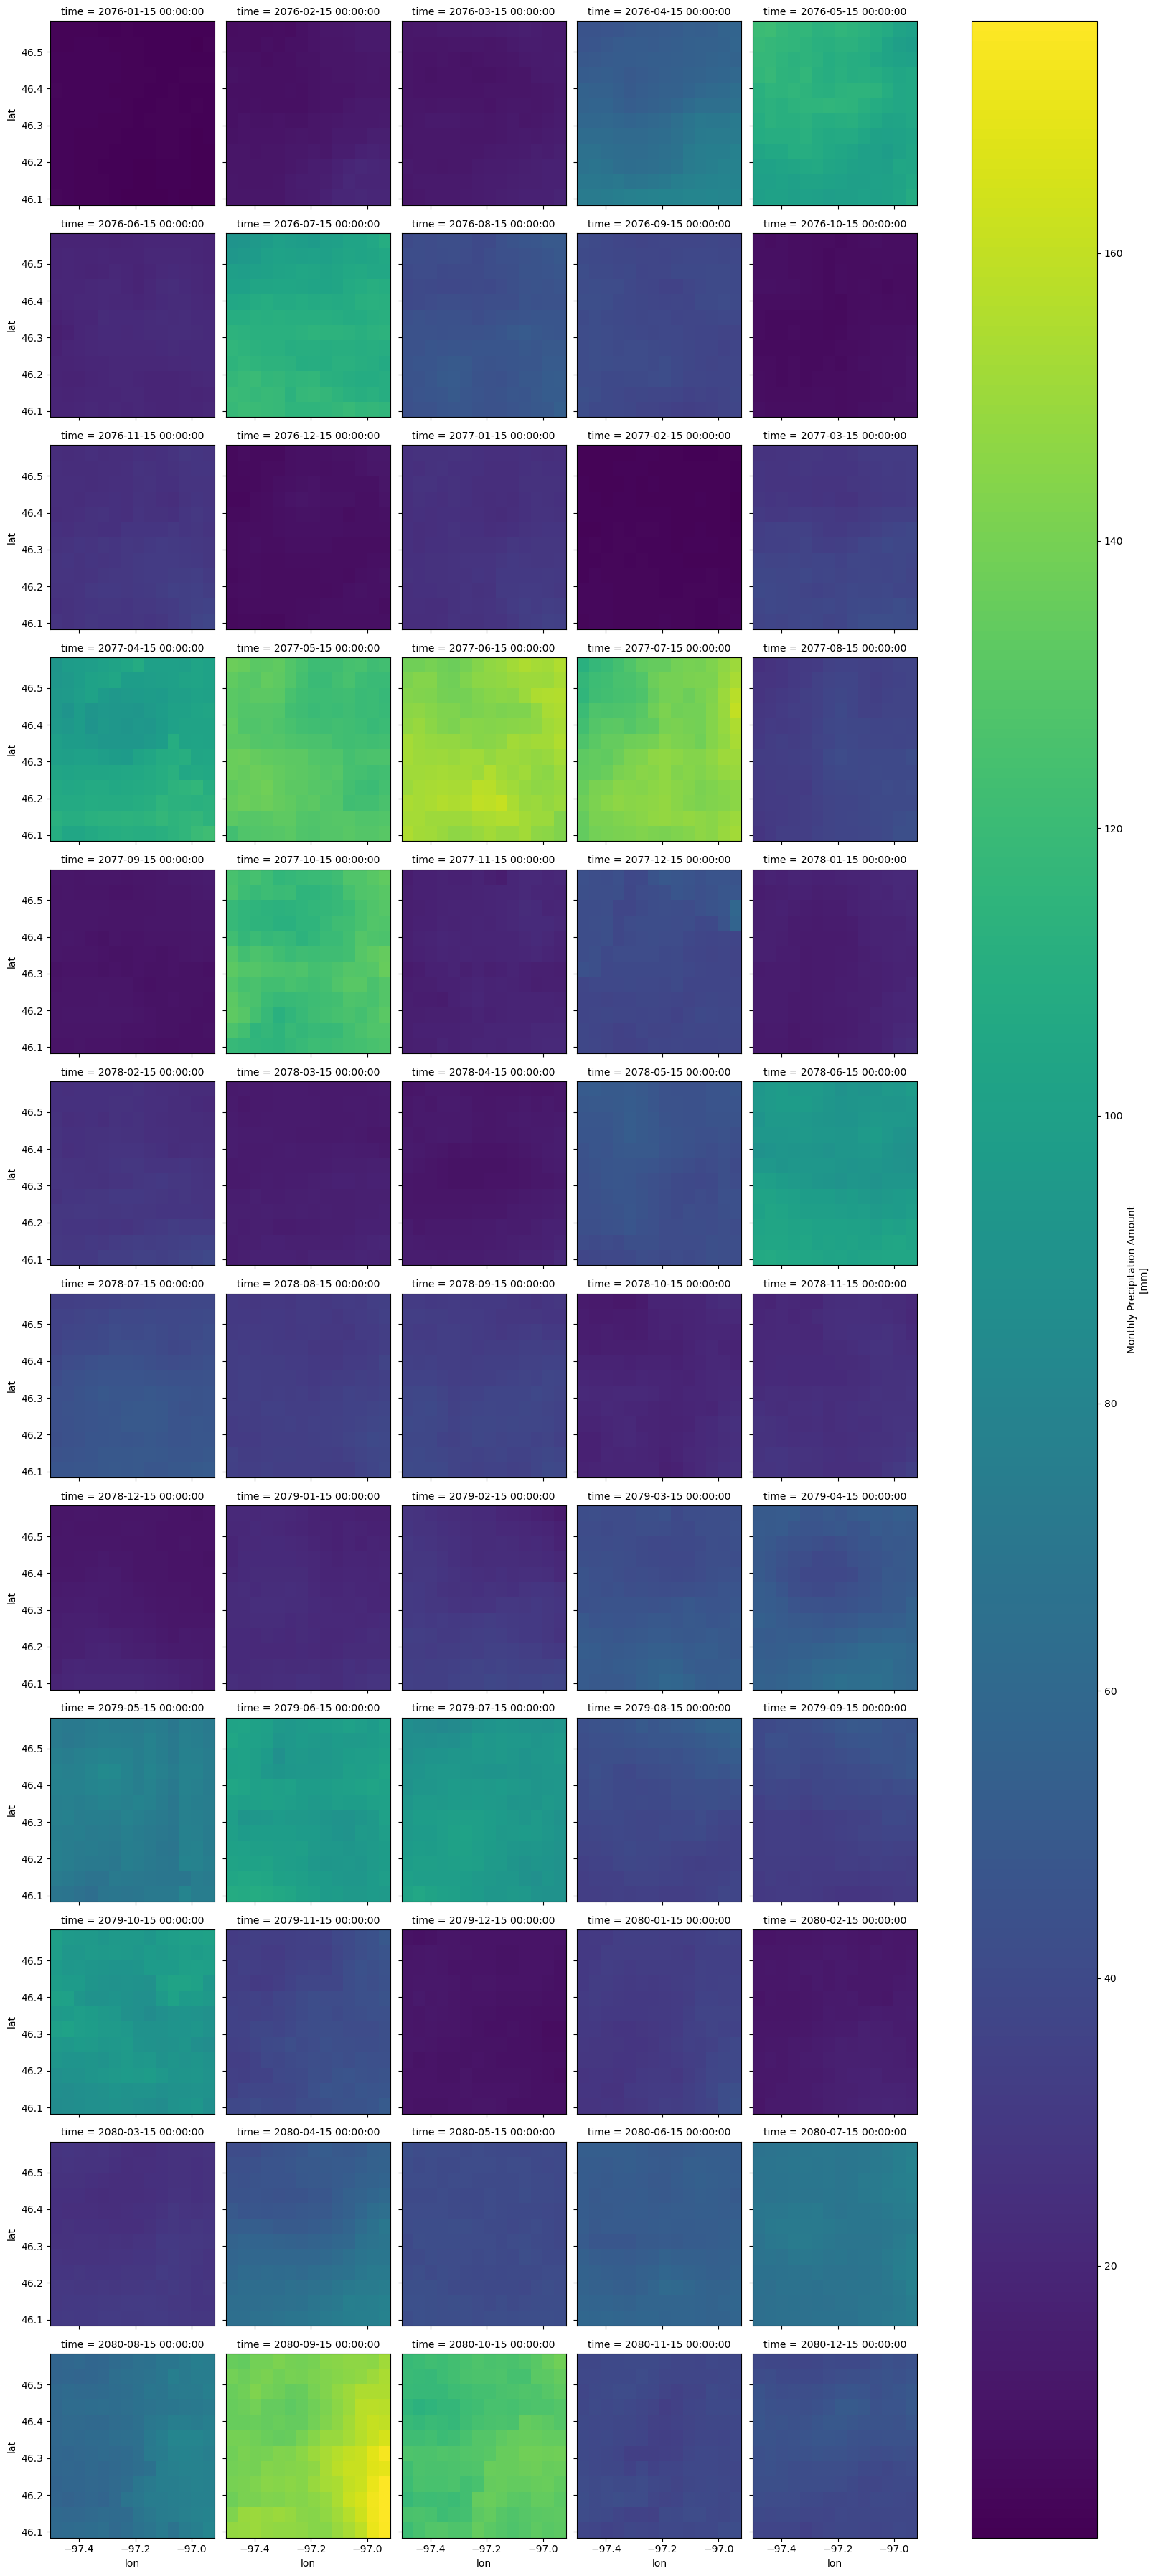

In [36]:
sheyenne_85_da.plot(col='time',
                    col_wrap=5)
plt.show

In [ ]:
# Find the average precipitation for each pixel across all months for each individual year?
sheyenne_85_yearly_precip_da= sheyenne_85_da.groupby('time.year').mean()
sheyenne_85_yearly_precip_da

<xarray.DataArray 'precipitation' (year: 5, lat: 12, lon: 14)> Size: 3kB
array([[[38.74452 , 38.88535 , 39.07262 , 39.095417, 39.194164,
         39.09513 , 39.02252 , 39.236656, 39.295612, 40.08074 ,
         40.6553  , 41.00414 , 41.5277  , 42.618725],
        [38.595493, 38.619667, 38.697205, 38.810036, 38.84493 ,
         38.64655 , 39.06844 , 39.135784, 39.207325, 39.582844,
         40.15372 , 40.360905, 41.082394, 41.342503],
        [38.20163 , 38.572803, 38.72523 , 38.40859 , 38.790253,
         38.83014 , 38.650276, 38.952263, 38.488365, 39.167225,
         39.91917 , 40.004154, 40.876904, 40.975964],
        [37.99474 , 38.721424, 38.2832  , 38.48022 , 38.66843 ,
         38.684673, 38.01252 , 38.343407, 38.411602, 39.083714,
         39.3909  , 39.498978, 40.248585, 40.362904],
        [38.000095, 38.44366 , 38.354675, 38.183743, 38.385674,
         38.001156, 38.11402 , 38.320187, 38.595844, 39.051716,
         39.21731 , 38.851166, 39.26408 , 39.511585],
        [37.416744, 37.965725, 38.092842, 37.954132, 38.069115,
         37.750523, 37.881756, 38.48657 , 39.19797 , 39.50542 ,
         39.59436 , 38.996666, 38.915215, 39.348072],
        [36.92488 , 37.24768 , 37.304356, 37.113605, 37.30068 ,
         37.097263, 37.39558 , 37.64873 , 37.904842, 38.290325,
...
         58.10567 , 58.3822  , 59.48198 , 60.858784, 62.28339 ,
         63.334515, 64.16546 , 64.90769 , 65.54627 ],
        [57.33336 , 57.498226, 57.51941 , 57.040176, 56.986145,
         57.59212 , 58.27931 , 58.50194 , 59.780243, 60.90163 ,
         62.56943 , 63.254776, 64.11404 , 64.68314 ],
        [56.666306, 56.247852, 56.57562 , 56.176056, 56.198578,
         56.7571  , 56.9081  , 57.62837 , 58.715885, 59.2961  ,
         61.58043 , 62.36134 , 62.84284 , 63.21025 ],
        [55.716976, 55.87074 , 56.179195, 56.162914, 55.6694  ,
         56.10278 , 56.44583 , 57.339603, 58.086304, 59.138   ,
         60.34727 , 61.528385, 61.85744 , 62.497253],
        [55.984295, 56.214397, 56.68497 , 56.591385, 56.77661 ,
         56.721714, 57.063465, 57.494095, 58.583405, 59.262363,
         60.356125, 61.347927, 61.741634, 62.41836 ],
        [55.811512, 55.82188 , 56.011547, 56.621567, 56.93974 ,
         57.590588, 57.700626, 57.836094, 58.35866 , 58.595444,
         59.76387 , 60.26956 , 61.18188 , 62.19266 ],
        [55.089054, 55.09085 , 56.04057 , 56.126633, 56.898075,
         57.048145, 57.468395, 57.52821 , 57.779327, 58.222332,
         58.885315, 60.246037, 60.983448, 61.878693]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 96B 46.1 46.15 46.19 46.23 ... 46.48 46.52 46.56
  * lon      (lon) float64 112B -97.48 -97.44 -97.4 ... -97.02 -96.98 -96.94
    crs      int64 8B 0
  * year     (year) int64 40B 2076 2077 2078 2079 2080
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [ ]:
# 2076 has 12 months, each month has 14 pixels?
sheyenne_85_yearly_precip_da['year' == 2076]

<xarray.DataArray 'precipitation' (lat: 12, lon: 14)> Size: 672B
array([[38.74452 , 38.88535 , 39.07262 , 39.095417, 39.194164, 39.09513 ,
        39.02252 , 39.236656, 39.295612, 40.08074 , 40.6553  , 41.00414 ,
        41.5277  , 42.618725],
       [38.595493, 38.619667, 38.697205, 38.810036, 38.84493 , 38.64655 ,
        39.06844 , 39.135784, 39.207325, 39.582844, 40.15372 , 40.360905,
        41.082394, 41.342503],
       [38.20163 , 38.572803, 38.72523 , 38.40859 , 38.790253, 38.83014 ,
        38.650276, 38.952263, 38.488365, 39.167225, 39.91917 , 40.004154,
        40.876904, 40.975964],
       [37.99474 , 38.721424, 38.2832  , 38.48022 , 38.66843 , 38.684673,
        38.01252 , 38.343407, 38.411602, 39.083714, 39.3909  , 39.498978,
        40.248585, 40.362904],
       [38.000095, 38.44366 , 38.354675, 38.183743, 38.385674, 38.001156,
        38.11402 , 38.320187, 38.595844, 39.051716, 39.21731 , 38.851166,
        39.26408 , 39.511585],
       [37.416744, 37.965725, 38.092842, 37.954132, 38.069115, 37.750523,
        37.881756, 38.48657 , 39.19797 , 39.50542 , 39.59436 , 38.996666,
        38.915215, 39.348072],
       [36.92488 , 37.24768 , 37.304356, 37.113605, 37.30068 , 37.097263,
        37.39558 , 37.64873 , 37.904842, 38.290325, 38.415527, 38.216175,
        38.42972 , 38.555805],
       [36.212242, 36.5573  , 36.811474, 36.93062 , 36.487423, 36.279354,
        36.310535, 36.76807 , 36.958942, 37.063625, 37.860085, 38.20106 ,
        38.2204  , 38.23956 ],
       [35.80058 , 36.06838 , 35.95683 , 35.98046 , 35.997746, 35.93356 ,
        35.54038 , 35.759064, 35.916573, 36.675415, 37.16083 , 37.45267 ,
        37.578808, 37.810974],
       [35.57076 , 35.59034 , 35.49434 , 35.217747, 35.767277, 35.675987,
        35.665928, 35.97851 , 36.276615, 36.495853, 36.828785, 37.072094,
        36.915344, 36.860104],
       [34.92445 , 35.02716 , 35.054615, 35.473873, 35.68646 , 35.37788 ,
        35.185833, 35.89625 , 36.25133 , 36.545162, 36.96922 , 36.75454 ,
        36.6924  , 37.116238],
       [34.81307 , 34.915623, 34.798386, 34.98437 , 35.21593 , 34.877308,
        35.160122, 35.66094 , 36.204067, 36.72963 , 37.143208, 37.18825 ,
        37.39797 , 37.47961 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 96B 46.1 46.15 46.19 46.23 ... 46.48 46.52 46.56
  * lon      (lon) float64 112B -97.48 -97.44 -97.4 ... -97.02 -96.98 -96.94
    crs      int64 8B 0
    year     int64 8B 2076
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [ ]:
# Calculate the total annual precipitation for each year?
sheyenne_85_annual_precip = sheyenne_85_yearly_precip_da.groupby('year').sum(["lat", "lon"])
sheyenne_85_annual_precip

<xarray.DataArray 'precipitation' (year: 5)> Size: 20B
array([ 6349.2065, 11343.829 ,  5335.2256,  8873.752 , 10050.089 ],
      dtype=float32)
Coordinates:
    crs      int64 8B 0
  * year     (year) int64 40B 2076 2077 2078 2079 2080
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [31]:
maca_da_list[0]

{'site_name': 'Sheyenne Grasslands',
 'rcp_value': 'rcp85',
 'da': <xarray.DataArray 'precipitation' (time: 60, lat: 12, lon: 14)> Size: 40kB
 [10080 values with dtype=float32]
 Coordinates:
   * lat      (lat) float64 96B 46.1 46.15 46.19 46.23 ... 46.48 46.52 46.56
   * time     (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:00:00
   * lon      (lon) float64 112B -97.48 -97.44 -97.4 ... -97.02 -96.98 -96.94
     crs      int64 8B 0
 Attributes:
     long_name:      Monthly Precipitation Amount
     units:          mm
     standard_name:  precipitation
     cell_methods:   time: sum(interval: 24 hours): sum over days
     comments:       Total monthly precipitation at surface: includes both liq...
     _ChunkSizes:    [ 10  44 107]}

### Looking at an individual data array

In [6]:
# Define url
maca_85_url = (
            'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
            '/MACAV2/CanESM2'
            '/macav2metdata_pr_CanESM2_r1i1p1'
            '_rcp85'
            '_2076_2080_CONUS'
            '_monthly.nc')
maca_85_url

'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2/macav2metdata_pr_CanESM2_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc'

In [7]:
# Open maca_85_url
maca_85_da = xr.open_dataset(maca_85_url).squeeze().precipitation
maca_85_da

<xarray.DataArray 'precipitation' (time: 60, lat: 585, lon: 1386)> Size: 195MB
[48648600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 5kB 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
    crs      int32 4B 1
  * lon      (lon) float64 11kB 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time     (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:00:00
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    grid_mapping:   crs
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

### Following the old textbook steps...

In [8]:
# Open maca_85_url
maca_85_xr = xr.open_dataset(maca_85_url)
maca_85_xr

<xarray.Dataset> Size: 195MB
Dimensions:        (lat: 585, crs: 1, lon: 1386, time: 60)
Coordinates:
  * lat            (lat) float64 5kB 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs            (crs) int32 4B 1
  * lon            (lon) float64 11kB 235.2 235.3 235.3 ... 292.9 292.9 292.9
  * time           (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:0...
Data variables:
    precipitation  (time, lat, lon) float32 195MB ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [9]:
climate_crs = maca_85_xr.rio.crs
climate_crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

In [10]:
maca_85_xr['precipitation']['lat'].values[:5]

array([25.06307793, 25.10474396, 25.14640999, 25.18807602, 25.22974205])

In [11]:
print("The min and max latitude values in the data is:", 
      maca_85_xr["precipitation"]["lat"].values.min(), 
      maca_85_xr["precipitation"]["lat"].values.max())
print("The min and max longitude values in the data is:", 
      maca_85_xr["precipitation"]["lon"].values.min(), 
      maca_85_xr["precipitation"]["lon"].values.max())

The min and max latitude values in the data is: 25.063077926635742 49.39602279663086
The min and max longitude values in the data is: 235.22784423828125 292.93524169921875


In [12]:
# View first 5 and last 5 time values - notice the span of
# dates range from 1950 to 2005
print("The earliest date in the data is:", maca_85_xr["precipitation"]["time"].values.min())
print("The latest date in the data is:", maca_85_xr["precipitation"]["time"].values.max())   

The earliest date in the data is: 2076-01-15 00:00:00
The latest date in the data is: 2080-12-15 00:00:00


In [13]:
# What is the shape of the time values?
maca_85_xr["precipitation"]["time"].values.shape

# Output tells us there are 60 months worth of data

(60,)

In [14]:
# View metadata
metadata = maca_85_xr.attrs
metadata

{'description': 'Multivariate Adaptive Constructed Analogs (MACA) method, version 2.3,Dec 2013.',
 'id': 'MACAv2-METDATA',
 'naming_authority': 'edu.uidaho.reacch',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'Metadata_Link': '',
 'cdm_data_type': 'FLOAT',
 'title': 'Monthly aggregation of downscaled daily meteorological data of Monthly Precipitation Amount from Canadian Centre for Climate Modelling and Analysis (CanESM2) using the run r1i1p1 of the rcp85 scenario.',
 'summary': 'This archive contains monthly downscaled meteorological and hydrological projections for the Conterminous United States at 1/24-deg resolution. These monthly values are obtained by aggregating the daily values obtained from the downscaling using the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the METDATA (Abatzoglou,2013) training dataset. The downscaled meteorological variables are maximum/minimum temperature(tasmax/tasmin), maximum/mi

In [15]:
# View data title
metadata['title']

'Monthly aggregation of downscaled daily meteorological data of Monthly Precipitation Amount from Canadian Centre for Climate Modelling and Analysis (CanESM2) using the run r1i1p1 of the rcp85 scenario.'

In [16]:
maca_85_xr

<xarray.Dataset> Size: 195MB
Dimensions:        (lat: 585, crs: 1, lon: 1386, time: 60)
Coordinates:
  * lat            (lat) float64 5kB 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs            (crs) int32 4B 1
  * lon            (lon) float64 11kB 235.2 235.3 235.3 ... 292.9 292.9 292.9
  * time           (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:0...
Data variables:
    precipitation  (time, lat, lon) float32 195MB ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [17]:
sheyenne_grasslands_gdf.total_bounds

array([-97.46881033,  46.09534316, -96.93854828,  46.57204154])

In [18]:
# Convert Grassland Bounds into min and max longitude and latitude values
sheyenne_lat = [float(sheyenne_grasslands_gdf.total_bounds[1]), float(sheyenne_grasslands_gdf.total_bounds[3])]
sheyenne_lon = [float(sheyenne_grasslands_gdf.total_bounds[0]), float(sheyenne_grasslands_gdf.total_bounds[2])]
# Notice that the longitude values have negative numbers
# we need these values in a global crs so we can subtract from 360
sheyenne_lat, sheyenne_lon

([46.0953431579286, 46.57204154162918],
 [-97.46881033436894, -96.93854828332353])

In [19]:
# The netcdf files use a global lat/lon so adjust values accordingly
sheyenne_lon[0] = sheyenne_lon[0] + 360
sheyenne_lon[1] = sheyenne_lon[1] + 360
sheyenne_lon

[262.5311896656311, 263.06145171667646]

In [20]:
# Slice the data by spatial extent
sheyenne_85_xr = maca_85_xr["precipitation"].sel(
    lon=slice(sheyenne_lon[0], sheyenne_lon[1]),
    lat=slice(sheyenne_lat[0], sheyenne_lat[1]))
sheyenne_85_xr

<xarray.DataArray 'precipitation' (time: 60, lat: 12, lon: 13)> Size: 37kB
[9360 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 96B 46.1 46.15 46.19 46.23 ... 46.48 46.52 46.56
  * lon      (lon) float64 104B 262.6 262.6 262.6 262.7 ... 263.0 263.0 263.1
  * time     (time) object 480B 2076-01-15 00:00:00 ... 2080-12-15 00:00:00
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    grid_mapping:   crs
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

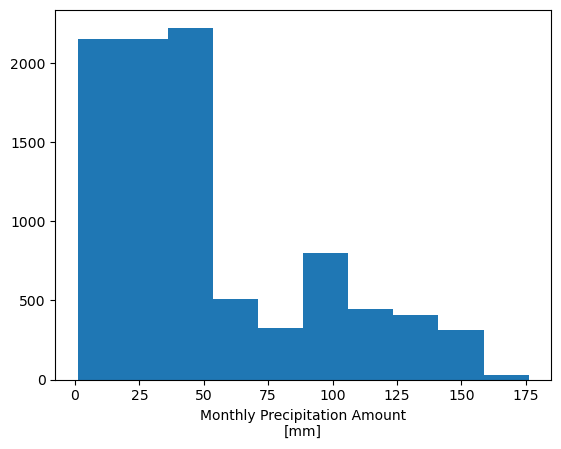

In [21]:
sheyenne_85_xr.plot()
plt.show()
# The plot is a histogram showing the spread of monthly precipitation amounts (mm) over time for rcp 8.5 in the sheyenne grasslands.

<function matplotlib.pyplot.show(close=None, block=None)>

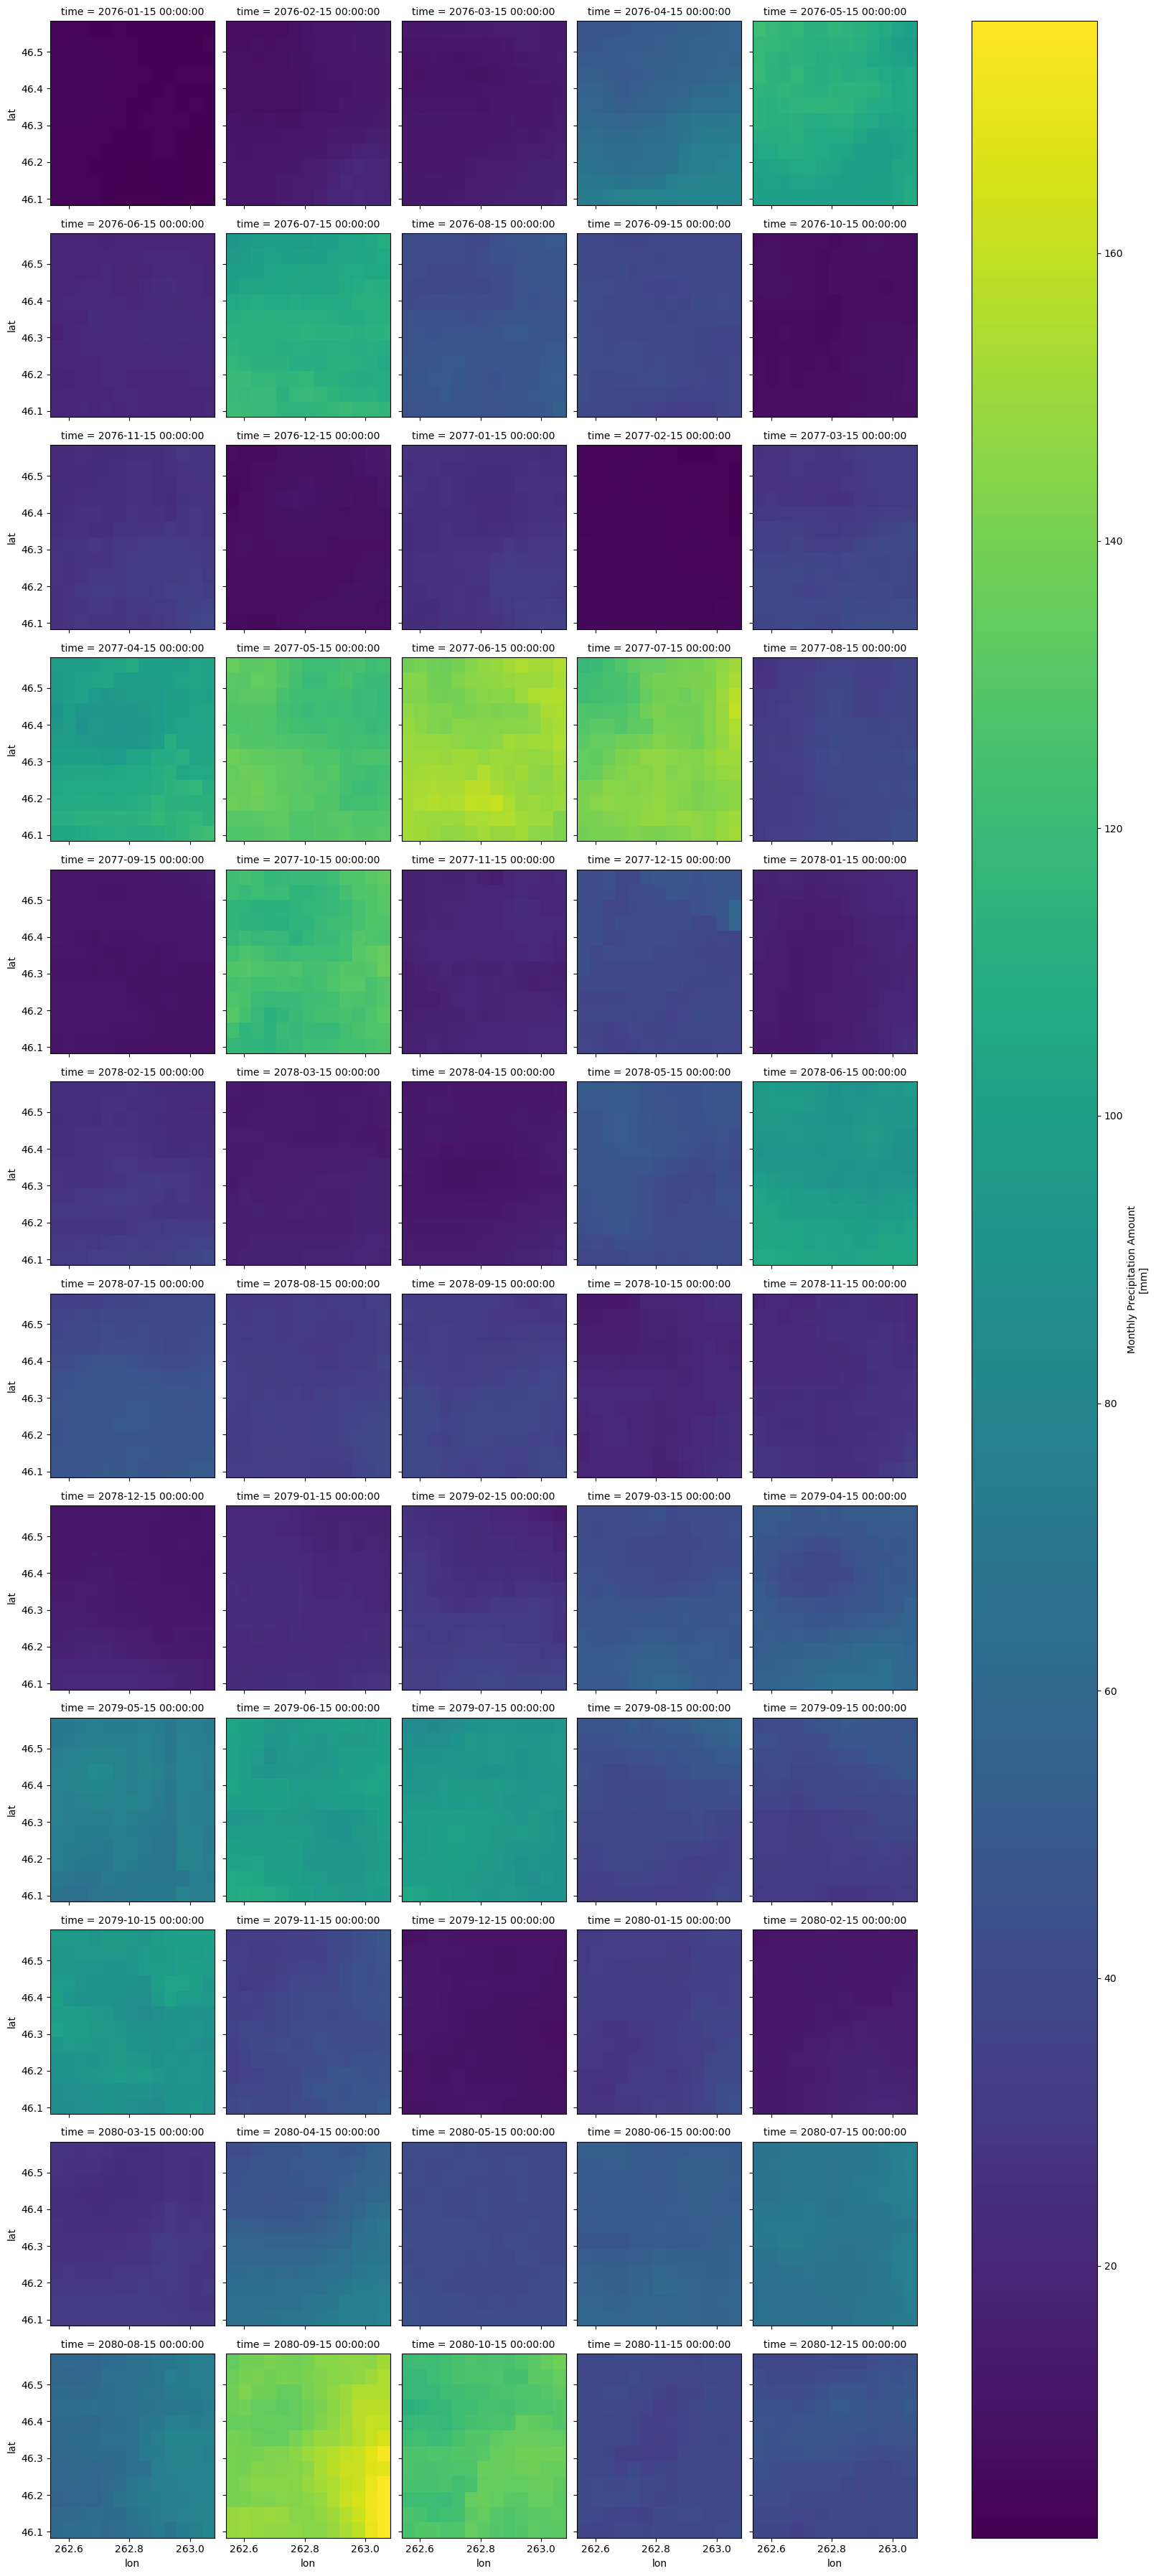

In [22]:
sheyenne_85_xr.plot(col='time',
                    col_wrap=5)
plt.show
# Output: spatial plots of monthly precip (mm) for each month from Jan 2076 to Dec 2080

#### Calculate Annual summary data

In [26]:
# Calculate a summary of mean precip over time for Sheyenne
# this is the mean value in each pixel accross all months for each year
sheyenne_85_annual_mean = sheyenne_85_xr.groupby('time.year').mean(skipna=True)
sheyenne_85_annual_mean

<xarray.DataArray 'precipitation' (year: 5, lat: 12, lon: 13)> Size: 3kB
array([[[38.88535 , 39.07262 , 39.095417, 39.194164, 39.09513 ,
         39.02252 , 39.236656, 39.295612, 40.08074 , 40.6553  ,
         41.00414 , 41.5277  , 42.618725],
        [38.619667, 38.697205, 38.810036, 38.84493 , 38.64655 ,
         39.06844 , 39.135784, 39.207325, 39.582844, 40.15372 ,
         40.360905, 41.082394, 41.342503],
        [38.572803, 38.72523 , 38.40859 , 38.790253, 38.83014 ,
         38.650276, 38.952263, 38.488365, 39.167225, 39.91917 ,
         40.004154, 40.876904, 40.975964],
        [38.721424, 38.2832  , 38.48022 , 38.66843 , 38.684673,
         38.01252 , 38.343407, 38.411602, 39.083714, 39.3909  ,
         39.498978, 40.248585, 40.362904],
        [38.44366 , 38.354675, 38.183743, 38.385674, 38.001156,
         38.11402 , 38.320187, 38.595844, 39.051716, 39.21731 ,
         38.851166, 39.26408 , 39.511585],
        [37.965725, 38.092842, 37.954132, 38.069115, 37.750523,
         37.881756, 38.48657 , 39.19797 , 39.50542 , 39.59436 ,
         38.996666, 38.915215, 39.348072],
        [37.24768 , 37.304356, 37.113605, 37.30068 , 37.097263,
         37.39558 , 37.64873 , 37.904842, 38.290325, 38.415527,
...
         58.3822  , 59.48198 , 60.858784, 62.28339 , 63.334515,
         64.16546 , 64.90769 , 65.54627 ],
        [57.498226, 57.51941 , 57.040176, 56.986145, 57.59212 ,
         58.27931 , 58.50194 , 59.780243, 60.90163 , 62.56943 ,
         63.254776, 64.11404 , 64.68314 ],
        [56.247852, 56.57562 , 56.176056, 56.198578, 56.7571  ,
         56.9081  , 57.62837 , 58.715885, 59.2961  , 61.58043 ,
         62.36134 , 62.84284 , 63.21025 ],
        [55.87074 , 56.179195, 56.162914, 55.6694  , 56.10278 ,
         56.44583 , 57.339603, 58.086304, 59.138   , 60.34727 ,
         61.528385, 61.85744 , 62.497253],
        [56.214397, 56.68497 , 56.591385, 56.77661 , 56.721714,
         57.063465, 57.494095, 58.583405, 59.262363, 60.356125,
         61.347927, 61.741634, 62.41836 ],
        [55.82188 , 56.011547, 56.621567, 56.93974 , 57.590588,
         57.700626, 57.836094, 58.35866 , 58.595444, 59.76387 ,
         60.26956 , 61.18188 , 62.19266 ],
        [55.09085 , 56.04057 , 56.126633, 56.898075, 57.048145,
         57.468395, 57.52821 , 57.779327, 58.222332, 58.885315,
         60.246037, 60.983448, 61.878693]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 96B 46.1 46.15 46.19 46.23 ... 46.48 46.52 46.56
  * lon      (lon) float64 104B 262.6 262.6 262.6 262.7 ... 263.0 263.0 263.1
  * year     (year) int64 40B 2076 2077 2078 2079 2080
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    grid_mapping:   crs
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [24]:
# Calculate annual summary data
sheyenne_85_annual_mean_val = sheyenne_85_annual_mean.groupby('year').mean(["lat", "lon"])
sheyenne_85_annual_mean_val

<xarray.DataArray 'precipitation' (year: 5)> Size: 20B
array([37.85902 , 67.62823 , 31.791811, 52.814304, 60.034466],
      dtype=float32)
Coordinates:
  * year     (year) int64 40B 2076 2077 2078 2079 2080
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    grid_mapping:   crs
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

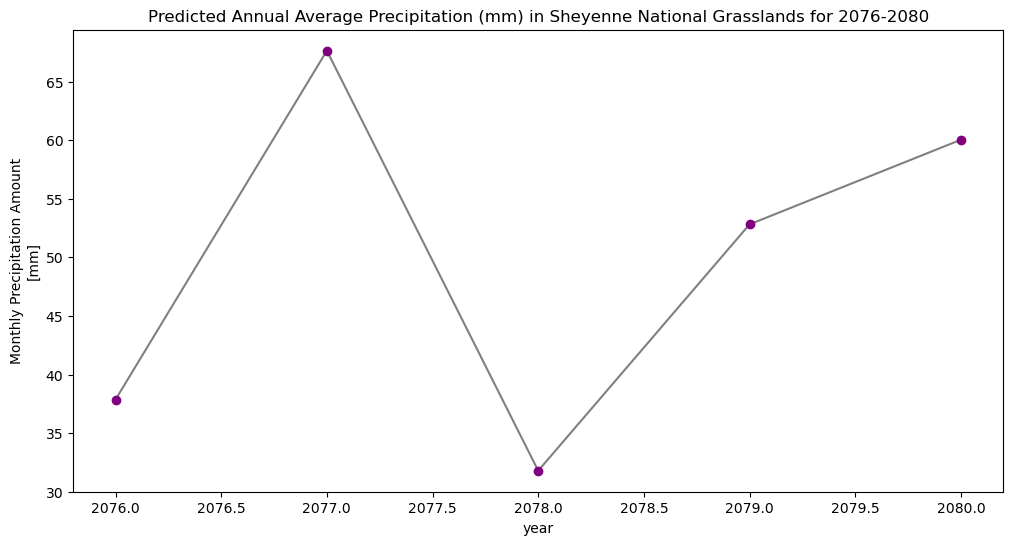

In [25]:
# Plot the data
f, ax = plt.subplots(figsize=(12, 6))
sheyenne_85_annual_mean_val.plot.line(hue='lat',
                              marker="o",
                              ax=ax,
                              color="grey",
                              markerfacecolor="purple",
                              markeredgecolor="purple")
ax.set(title="Predicted Annual Average Precipitation (mm) in Sheyenne National Grasslands for 2076-2080")
plt.show()

Subset a netcdf4 Using a Shapefile Feature or Features:

[Text(0.5, 1.0, 'Sheyenne National Grasslands AOI Subset')]

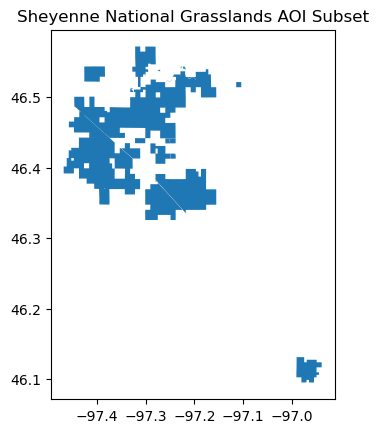

In [27]:
# This is the AOI of interest. You only want to calculate summary values for
# pixels within this AOI rather the entire rectangular spatial extent.
f, ax = plt.subplots()
sheyenne_grasslands_gdf.plot(ax=ax)
ax.set(title="Sheyenne National Grasslands AOI Subset")

In [26]:
# Define bounds
bounds_maca = (sheyenne_grasslands_gdf
                .to_crs(climate_crs)
                .total_bounds)

In [27]:
bounds_maca

array([-97.46881033,  46.09534316, -96.93854828,  46.57204154])

In [28]:
# Change maca_85_ds longitude values to match the grasslands gdfs
maca_85_xr = maca_85_xr.assign_coords(
    lon=("lon", [convert_longitude(l) for l in maca_85_xr.lon.values]))

# Set spatial dimensions of maca_85_da
maca_85_xr = maca_85_xr.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

# Crop maca_85_da
maca_85_xr = maca_85_xr.rio.clip_box(minx = -97.46881033,  miny = 46.09534316, maxx = -96.93854828,  maxy = 46.57204154)
maca_85_xr

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'.

In [ ]:
maca_85_df = pd.DataFrame(maca_85_da[precipitation])
maca_85_df

AttributeError: 'DataArray' object has no attribute 'precipitation'